# Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Make 1000 samples
n_samples = 1000
# Create Circles
X, y = make_circles(n_samples, noise= 0.03, random_state= 42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[1]

array([-0.75615888,  0.15325888])

In [5]:
# Make Dataframe
circles = pd.DataFrame({"X1": X[:,0], "X2":X[:,1], "label":y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


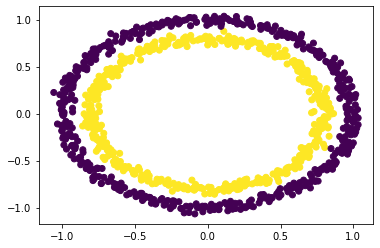

In [6]:
# Visualize Data
plt.scatter(X[:,0],X[:,1],c=y)

# Turn data into tensors and create train and test splits

In [7]:
import torch

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.33, random_state = 42)

# Building a model

In [11]:
from torch import nn

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# 1. Subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # Because we have two features, 5 is arbitrary number we can change it
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # Train data -> layer_1 -> layer_2 -> output
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Replicate the model above using nn.Sequential()

In [17]:
model_0 = nn.Sequential(nn.Linear(in_features= 2, out_features= 5), nn.Linear(in_features=5, out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Update our class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(nn.Linear(in_features= 2, out_features= 5),
                                               nn.Linear(in_features=5, out_features=1))

    def forward(self, x):
        return two_linear_layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [18]:
# Make predictions
untrained_preds = model_0(X_test.to(device))
print(f"First 10 predictions: {untrained_preds[:10]}")
print(f"First 10 labels: {y_test[:10]}")

First 10 predictions: tensor([[-0.4618],
        [-0.4675],
        [-0.4097],
        [-0.4768],
        [-0.3507],
        [-0.3547],
        [-0.4175],
        [-0.3909],
        [-0.4123],
        [-0.4673]], device='cuda:0', grad_fn=<SliceBackward0>)
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
# Setup a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [20]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train Model

* 1. Forward pass
* 2. Calculate the loss
* 3. Optimizer zero grad
* 4. Loss backward(backpropagation)
* 5. Optimizer step(gradient descent)

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ###Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels
    
    # 2. Calculate accuracy
    loss = loss_fn(y_logits, y_train) # Because we used BCEWithLogitsLoss() so this function needs logits as an input
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (Backpropagation)
    loss.backward()
    
    # 5. Optimizer step (Gradient Descent)
    optimizer.step()
    
    ###Testing
    model_0.eval()
    with torch.inference_mode():
        # 1.Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2.Calculate test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred= test_pred)
    if epoch % 10 == 0:
        print(f"epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f}% Test Loss: {test_loss:.5f} Test_acc: {test_acc:.2f}%")
    

epoch: 0 Loss: 0.71994 Acc: 48.66% Test Loss: 0.70095 Test_acc: 5.3e+01%
epoch: 10 Loss: 0.70465 Acc: 48.66% Test Loss: 0.69369 Test_acc: 5.3e+01%
epoch: 20 Loss: 0.69790 Acc: 48.66% Test Loss: 0.6921 Test_acc: 5.3e+01%
epoch: 30 Loss: 0.69490 Acc: 48.66% Test Loss: 0.69249 Test_acc: 5.3e+01%
epoch: 40 Loss: 0.69355 Acc: 46.42% Test Loss: 0.69339 Test_acc: 4.8e+01%
epoch: 50 Loss: 0.69294 Acc: 51.64% Test Loss: 0.69429 Test_acc: 4.7e+01%
epoch: 60 Loss: 0.69266 Acc: 52.39% Test Loss: 0.69503 Test_acc: 4.8e+01%
epoch: 70 Loss: 0.69253 Acc: 52.54% Test Loss: 0.69559 Test_acc: 4.9e+01%
epoch: 80 Loss: 0.69247 Acc: 53.43% Test Loss: 0.696 Test_acc: 5e+01%
epoch: 90 Loss: 0.69243 Acc: 54.63% Test Loss: 0.69629 Test_acc: 4.9e+01%


In [22]:
# Make predictions and evaluate the model
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Files are already exist")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

Files are already exist


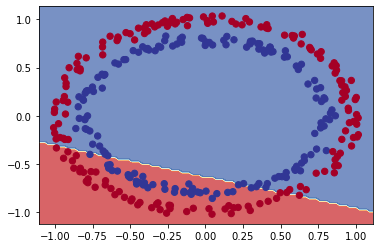

In [23]:
#Plot decision boundary to see errors
plot_decision_boundary(model_0, X_test,y_test)

# Improving Model

In [ ]:
# Add more layers
# Add more hidden units
# Fit for longer (more epochs)
# Changing the activation functions
# Change the learning rate
# Change the loss function

In [25]:
#New model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [26]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ###Train
    model_1.train()
    #1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward
    loss.backward()
    
    #5. Optimizer step
    optimizer.step()
    
    ###Test
    model_1.eval()
    with torch.inference_mode():
        #1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #2. Calculate the loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred= test_pred)
        
    if epoch % 100 == 0:
        print(f"epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f}% Test Loss: {test_loss:.5f} Test_acc: {test_acc:.2f}%")

epoch: 0 Loss: 0.69351 Acc: 51.79% Test Loss: 0.69411 Test_acc: 49.70%
epoch: 100 Loss: 0.69248 Acc: 58.06% Test Loss: 0.69612 Test_acc: 51.21%
epoch: 200 Loss: 0.69240 Acc: 57.16% Test Loss: 0.69673 Test_acc: 52.42%
epoch: 300 Loss: 0.69239 Acc: 55.52% Test Loss: 0.69698 Test_acc: 49.70%
epoch: 400 Loss: 0.69239 Acc: 55.07% Test Loss: 0.69706 Test_acc: 50.30%
epoch: 500 Loss: 0.69239 Acc: 54.93% Test Loss: 0.69709 Test_acc: 49.70%
epoch: 600 Loss: 0.69239 Acc: 54.93% Test Loss: 0.69710 Test_acc: 50.00%
epoch: 700 Loss: 0.69239 Acc: 54.93% Test Loss: 0.69711 Test_acc: 50.30%
epoch: 800 Loss: 0.69238 Acc: 55.07% Test Loss: 0.69711 Test_acc: 50.30%
epoch: 900 Loss: 0.69239 Acc: 55.07% Test Loss: 0.69711 Test_acc: 50.30%


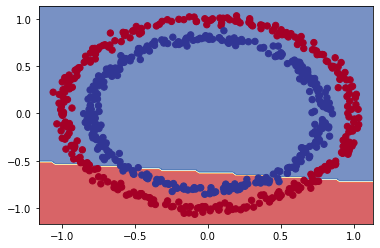

In [31]:
plot_decision_boundary(model_1, X_train, y_train)

# Non-Linear Models

In [32]:
class CirclerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non linear activation function
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [53]:
model_3 = CirclerModelV2().to(device)
model_3

CirclerModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
X_train.shape, y_test.shape

(torch.Size([670, 2]), torch.Size([330]))

In [55]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ###Training
    model_3.train()
    
    #Forward Pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    #Optimizer to grad
    optimizer.zero_grad()
    
    #Loss backward
    loss.backward()
    
    #Optimizer step
    optimizer.step()
    
    ###Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f}% Test Loss: {test_loss:.5f} Test_acc: {test_acc:.2f}%")

epoch: 0 Loss: 0.69273 Acc: 51.34% Test Loss: 0.69356 Test_acc: 47.27%
epoch: 100 Loss: 0.69099 Acc: 51.34% Test Loss: 0.69274 Test_acc: 47.27%
epoch: 200 Loss: 0.68962 Acc: 52.09% Test Loss: 0.69130 Test_acc: 47.58%
epoch: 300 Loss: 0.68773 Acc: 65.97% Test Loss: 0.68932 Test_acc: 60.61%
epoch: 400 Loss: 0.68495 Acc: 70.60% Test Loss: 0.68652 Test_acc: 68.18%
epoch: 500 Loss: 0.68081 Acc: 66.42% Test Loss: 0.68262 Test_acc: 65.76%
epoch: 600 Loss: 0.67469 Acc: 69.70% Test Loss: 0.67726 Test_acc: 68.18%
epoch: 700 Loss: 0.66567 Acc: 72.99% Test Loss: 0.66969 Test_acc: 72.42%
epoch: 800 Loss: 0.65099 Acc: 72.09% Test Loss: 0.65777 Test_acc: 71.52%
epoch: 900 Loss: 0.62401 Acc: 75.67% Test Loss: 0.63525 Test_acc: 72.42%
epoch: 1000 Loss: 0.57346 Acc: 84.48% Test Loss: 0.58814 Test_acc: 83.33%
epoch: 1100 Loss: 0.49355 Acc: 91.04% Test Loss: 0.51321 Test_acc: 88.48%
epoch: 1200 Loss: 0.39330 Acc: 95.97% Test Loss: 0.41768 Test_acc: 93.94%
epoch: 1300 Loss: 0.27924 Acc: 98.51% Test Loss: 0

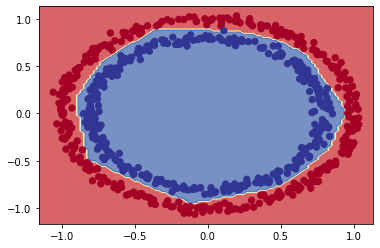

In [57]:
plot_decision_boundary(model_3,X_train,y_train)